In [1]:
# %%
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow import keras
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import csv


In [2]:
# %%
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200

In [3]:
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)

def roc_prc_ci(y_true, y_score, positive=1):
    AUC = average_precision_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)

In [4]:
train = pd.read_csv('train_cptdc_nopost_noint_80.csv')
test = pd.read_csv('test_cptdc_nopost_noint_20.csv')

# /home/loganlog/Documents/mbsaqip_bleed/data/train_cptdc_nopost_noint.csv

In [5]:
print(train.shape, test.shape)

(127967, 46) (31992, 46)


In [6]:
test.shape[0] / train.shape[0]

0.2500019536286699

In [7]:
data = pd.concat([train, test], axis=0)
data.head()

,SEX,AGE,CPT,GERD,MOBILITY_DEVICE,MI_ALL_HISTORY,PTC,PCARD,HIP,HYPERLIPIDEMIA,WGT_HIGH_BAR,WGT_CLOSEST,BMI,BMI_HIGH_BAR,HISTORY_DVT,VENOUS_STASIS,DIALYSIS,RENAL_INSUFFICIENCY,THERAPEUTIC_ANTICOAGULATION,PREVIOUS_SURGERY,DIABETES,SMOKER,FUNSTATPRESURG,COPD,OXYGEN_DEPENDENT,HISTORY_PE,SLEEP_APNEA,CHRONIC_STEROIDS,IVC_FILTER,IVC_TIMING,ALBUMIN,HCT,SURGICAL_APPROACH,ASACLASS,DTOP,OPYEAR,SURGSPECIALTY_BAR,CREATININE,HEMO,RACE_PUF,HISPANIC,NBHTN_MEDS,ROBOTIC_ASST,GITRACTBLEED,WEIGHT_DIFFERENCE,CPTLABEL
0,0,0.927530,0,0,0,0,0,0,1,0,-0.596203,-0.596278,-0.784649,-0.784679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-0.070922,0.534472,0,2,0,2020,3,-0.102827,-0.190060,7,0,2,0,0,-0.143388,1
1,0,-0.422138,0,0,0,0,0,0,0,0,1.392301,1.248903,1.215124,1.385497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-0.348976,-0.994028,0,2,0,2020,3,-0.384051,-0.542409,7,0,4,0,0,0.999967,1
2,0,-0.928264,2,0,0,0,0,0,0,0,-0.245184,-0.080993,0.011676,-0.192702,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1.875454,-0.270002,0,1,0,2020,3,-0.046582,-0.278147,5,2,4,1,0,-0.791788,2
3,0,-0.084721,2,0,0,0,0,0,0,0,-1.162175,-1.094411,-0.625896,-0.734943,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-1.183137,0.668551,0,1,0,2020,3,-0.402799,-0.190060,7,2,4,0,0,-0.590118,2
4,0,-0.843910,0,1,0,0,0,0,0,0,-0.024123,-0.250472,0.217798,0.508450,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,3,-1.183137,-0.564975,0,2,0,2020,3,0.515865,-0.894758,7,2,4,1,0,1.015480,1


In [8]:
# data.shape

In [9]:
# data.to_csv('../data/lucky_13.csv')

In [10]:
# data = pd.read_csv('/home/loganlog/Documents/mbsaqip_bleed/data/lucky_13.csv', index_col=1)

In [11]:
# %%
# drop = ['GITRACTBLEED']
# y = train['GITRACTBLEED']
# X = train.drop(drop, axis=1)
# y_test = test['GITRACTBLEED']
# X_test = test.drop(drop, axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=13)

In [12]:
data.shape

(159959, 46)

In [13]:
drop = ['GITRACTBLEED']
y = data['GITRACTBLEED']
X = data.drop(drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=13)

In [14]:
X_train.shape

(127967, 45)

In [15]:
X_test.shape

(31992, 45)

In [16]:
X_test.shape[0] / X.shape[0]

0.2000012503203946

In [17]:
# %%
y_train.value_counts()

0    127461
1       506
Name: GITRACTBLEED, dtype: int64

In [18]:
# %%
y.value_counts(normalize=True)

0    0.996049
1    0.003951
Name: GITRACTBLEED, dtype: float64

In [19]:
# %%
y_test.value_counts()

0    31866
1      126
Name: GITRACTBLEED, dtype: int64

In [20]:
# %%
X.head()

,SEX,AGE,CPT,GERD,MOBILITY_DEVICE,MI_ALL_HISTORY,PTC,PCARD,HIP,HYPERLIPIDEMIA,WGT_HIGH_BAR,WGT_CLOSEST,BMI,BMI_HIGH_BAR,HISTORY_DVT,VENOUS_STASIS,DIALYSIS,RENAL_INSUFFICIENCY,THERAPEUTIC_ANTICOAGULATION,PREVIOUS_SURGERY,DIABETES,SMOKER,FUNSTATPRESURG,COPD,OXYGEN_DEPENDENT,HISTORY_PE,SLEEP_APNEA,CHRONIC_STEROIDS,IVC_FILTER,IVC_TIMING,ALBUMIN,HCT,SURGICAL_APPROACH,ASACLASS,DTOP,OPYEAR,SURGSPECIALTY_BAR,CREATININE,HEMO,RACE_PUF,HISPANIC,NBHTN_MEDS,ROBOTIC_ASST,WEIGHT_DIFFERENCE,CPTLABEL
0,0,0.927530,0,0,0,0,0,0,1,0,-0.596203,-0.596278,-0.784649,-0.784679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-0.070922,0.534472,0,2,0,2020,3,-0.102827,-0.190060,7,0,2,0,-0.143388,1
1,0,-0.422138,0,0,0,0,0,0,0,0,1.392301,1.248903,1.215124,1.385497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-0.348976,-0.994028,0,2,0,2020,3,-0.384051,-0.542409,7,0,4,0,0.999967,1
2,0,-0.928264,2,0,0,0,0,0,0,0,-0.245184,-0.080993,0.011676,-0.192702,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1.875454,-0.270002,0,1,0,2020,3,-0.046582,-0.278147,5,2,4,1,-0.791788,2
3,0,-0.084721,2,0,0,0,0,0,0,0,-1.162175,-1.094411,-0.625896,-0.734943,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-1.183137,0.668551,0,1,0,2020,3,-0.402799,-0.190060,7,2,4,0,-0.590118,2
4,0,-0.843910,0,1,0,0,0,0,0,0,-0.024123,-0.250472,0.217798,0.508450,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,3,-1.183137,-0.564975,0,2,0,2020,3,0.515865,-0.894758,7,2,4,1,1.015480,1


In [21]:
X.shape

(159959, 45)

In [22]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: GITRACTBLEED, dtype: int64

In [23]:
y.shape

(159959,)

In [24]:
# %%
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [25]:
# %%
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [26]:
# %%
rf = RandomForestClassifier(n_estimators=1500, max_depth=20, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, bootstrap=True, n_jobs=-1, random_state=0)
xgb = XGBClassifier(n_estimators=100, max_depth=20, colsample_bytree=0.8, learning_rate=0.05, min_child_weight=4, subsample=1, random_state=0)
# xgb = XGBClassifier(n_estimators=100, max_depth=20, colsample_bytree=0.8, learning_rate=0.05, min_child_weight=4, subsample=1, tree_method='gpu_hist', random_state=0)
lr = LogisticRegression(penalty='none', random_state=0, max_iter=9999)

input_shape = X.shape[1:]
def build_model(n_hidden=3, n_neurons=1500, dropout=0.6, learning_rate=0.00003):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropout))
        model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(), metrics=['AUC'], optimizer=optimizer)
    return model
nn = build_model()


2022-09-21 20:26:36.434460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nas/longleaf/apps/julia/1.6.3/lib:/nas/longleaf/apps/cuda/11.4/lib64:/nas/longleaf/apps/cuda/11.4/extras/CUPTI/lib64:/nas/longleaf/rhel8/apps/gcc/9.1.0/lib:/nas/longleaf/rhel8/apps/gcc/9.1.0/lib64
2022-09-21 20:26:36.434485: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-21 20:26:36.434502: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c1416ood04.ll.unc.edu): /proc/driver/nvidia/version does not exist
2022-09-21 20:26:36.434676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical

In [27]:
# %%
#calculate 95% confidence interval for auroc and auprc for each model (def = define function)
def auroc_ci(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    mean = roc_auc
    std = sqrt(roc_auc * (1.0 - roc_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high
#calculate auprc 95% ci for each model
def auprc_ci(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    mean = pr_auc
    std = sqrt(pr_auc * (1.0 - pr_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high
def fit_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return y_pred_proba

In [28]:
# %%
# New
# cross_val_score(rf, X, y, scoring='roc_auc', cv=5)

# scores = cross_val_score(xgb, X, y, scoring='roc_auc', cv=5)
# import numpy as np
# np.mean(scores)

In [29]:
# %%
# rf_y_pred = fit_predict(rf, X, y, X_test)
# xgb_y_pred = fit_predict(xgb, X, y, X_test)
# lr_y_pred = fit_predict(lr, X, y, X_test)

In [30]:
# %%
rf_y_pred = fit_predict(rf, X_train, y_train, X_test)
xgb_y_pred = fit_predict(xgb, X_train, y_train, X_test)
lr_y_pred = fit_predict(lr, X_train, y_train, X_test)

In [31]:
# %%
history = nn.fit(X_train, y_train,
                batch_size=512, epochs=500,
                validation_data=(X_test, y_test),
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)])

Epoch 1/500
250/250 [==============================] - 45s 175ms/step - loss: 0.3114 - auc: 0.4653 - val_loss: 46.0768 - val_auc: 0.5000
Epoch 2/500
250/250 [==============================] - 43s 174ms/step - loss: 0.0732 - auc: 0.4492 - val_loss: 21.0792 - val_auc: 0.5000
Epoch 3/500
250/250 [==============================] - 44s 174ms/step - loss: 0.0436 - auc: 0.4803 - val_loss: 1.0308 - val_auc: 0.5216
Epoch 4/500
250/250 [==============================] - 43s 174ms/step - loss: 0.0364 - auc: 0.4902 - val_loss: 0.0939 - val_auc: 0.6776
Epoch 5/500
250/250 [==============================] - 43s 174ms/step - loss: 0.0325 - auc: 0.5023 - val_loss: 0.0936 - val_auc: 0.6781
Epoch 6/500
250/250 [==============================] - 43s 174ms/step - loss: 0.0315 - auc: 0.5370 - val_loss: 0.0773 - val_auc: 0.6833
Epoch 7/500
250/250 [==============================] - 43s 174ms/step - loss: 0.0303 - auc: 0.5448 - val_loss: 0.0705 - val_auc: 0.6879
Epoch 8/500
250/250 [=========================

In [32]:
# %%
# New

auroc_ci(y_test, xgb_y_pred)

(0.7324615557392021, 0.7349292025435878, 0.7373968493479736)

In [33]:
# %%
# New

auroc_ci(y_test, rf_y_pred)


(0.7501294875906259, 0.7525421432406935, 0.754954798890761)

In [34]:
# %%
# New

auroc_ci(y_test, lr_y_pred)

(0.6901390240187665, 0.6927184669135337, 0.6952979098083009)

In [35]:
X_train.shape

(127967, 45)

In [36]:
# %%
# New
y.value_counts(normalize=True)

0    0.996049
1    0.003951
Name: GITRACTBLEED, dtype: float64

In [37]:
# %%
# New
y_test.value_counts(normalize=True)

0    0.996062
1    0.003938
Name: GITRACTBLEED, dtype: float64

In [38]:
# install delong

In [39]:
# # %%
# # New

# p_val = delong.delong_roc_test(y_test, lr_y_pred, xgb_y_pred)
# p_val2 = delong.delong_roc_test(y_test, lr_y_pred, rf_y_pred)

In [40]:
# # %%
# # New

# 10 ** (p_val[0][0])

In [41]:
# # %%
# # New

# 10 ** (p_val2[0][0])

Text(0.5, 0, 'XGBoost Feature Importance')

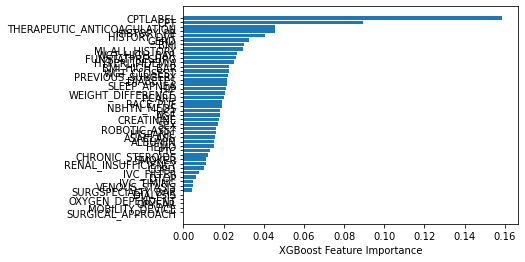

In [42]:
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

In [43]:
# %%
nn_y_pred = nn.predict(X_test)
rf_confidence = auroc_ci(y_test, rf_y_pred)
xgb_confidence = auroc_ci(y_test, xgb_y_pred)
lr_confidence = auroc_ci(y_test, lr_y_pred)
nn_confidence = auroc_ci(y_test, nn_y_pred)
print('Random Forest AUROC:', rf_confidence, 'AUROC CI:', rf_confidence)
print('XGBoost AUROC:', xgb_confidence, 'AUROC CI:', xgb_confidence)
print('Logistic Regression AUROC:', lr_confidence, 'AUROC CI:', lr_confidence)
print('Neural Network AUROC:', nn_confidence, 'AUROC CI:', nn_confidence)

1000/1000 [==============================] - 4s 3ms/step
Random Forest AUROC: (0.7501294875906259, 0.7525421432406935, 0.754954798890761) AUROC CI: (0.7501294875906259, 0.7525421432406935, 0.754954798890761)
XGBoost AUROC: (0.7324615557392021, 0.7349292025435878, 0.7373968493479736) AUROC CI: (0.7324615557392021, 0.7349292025435878, 0.7373968493479736)
Logistic Regression AUROC: (0.6901390240187665, 0.6927184669135337, 0.6952979098083009) AUROC CI: (0.6901390240187665, 0.6927184669135337, 0.6952979098083009)
Neural Network AUROC: (0.701467128230697, 0.7040192612118803, 0.7065713941930636) AUROC CI: (0.701467128230697, 0.7040192612118803, 0.7065713941930636)


In [44]:
# %%
#create labels for roc curves
rf_label = 'RF: ' + str(round(rf_confidence[1], 3)) + ' (' + str(round(rf_confidence[0], 3)) + ' - ' + str(round(rf_confidence[2], 3)) + ')'
xgb_label = 'XGB: ' + str(round(xgb_confidence[1], 3)) + ' (' + str(round(xgb_confidence[0], 3)) + ' - ' + str(round(xgb_confidence[2], 3)) + ')'
nn_label = 'NN: ' + str(round(nn_confidence[1], 3)) + ' (' + str(round(nn_confidence[0], 3)) + ' - ' + str(round(nn_confidence[2], 3)) + ')'
lr_label = 'LR: ' + str(round(lr_confidence[1], 3)) + ' (' + str(round(lr_confidence[0], 3)) + ' - ' + str(round(lr_confidence[2], 3)) + ')'
#calculate tpr and fpr for each model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_y_pred)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_pred)

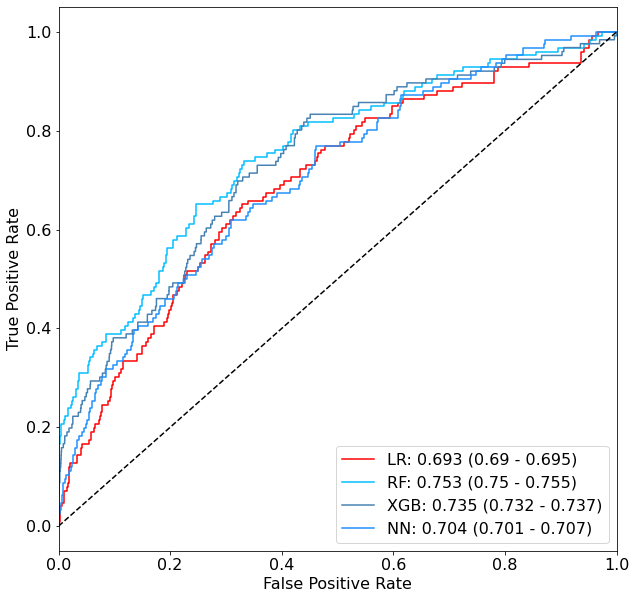

In [45]:
# %%
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
#plot the ROC curves for each model
plt.figure(figsize=(10,10))
plt.plot(lr_fpr, lr_tpr, color='red', label=lr_label)
plt.plot(rf_fpr, rf_tpr, color='deepskyblue', label=rf_label)
plt.plot(xgb_fpr, xgb_tpr, color='steelblue', label=xgb_label)
plt.plot(nn_fpr, nn_tpr, color='dodgerblue', label=nn_label)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.savefig('roc_bleed_cptdc_nopost_noint_ab.png')

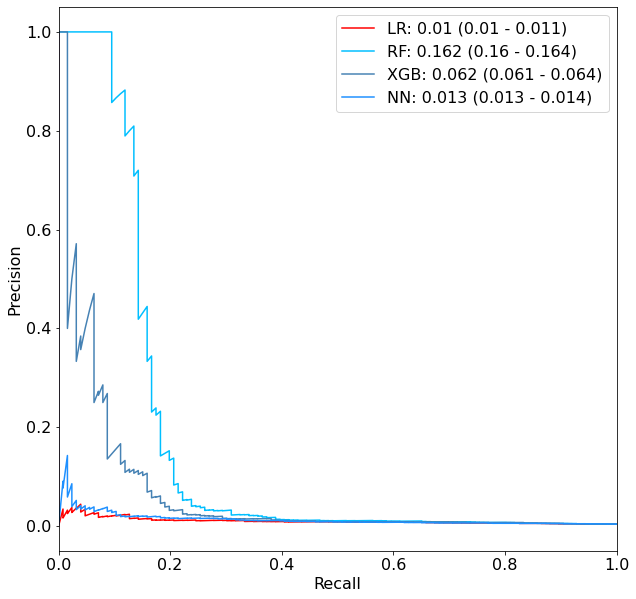

In [46]:
# %%
rf_auprc_ci = auprc_ci(y_test, rf_y_pred)
xgb_auprc_ci = auprc_ci(y_test, xgb_y_pred)
lr_auprc_ci = auprc_ci(y_test, lr_y_pred)
nn_auprc_ci = auprc_ci(y_test, nn_y_pred)
#calculate precision and recall for each model
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_y_pred)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_y_pred)
nn_precision, nn_recall, _ = precision_recall_curve(y_test, nn_y_pred)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_y_pred)
#create labels for precision recall curves
rf_prc_label = 'RF: ' + str(round(rf_auprc_ci[1], 3)) + ' (' + str(round(rf_auprc_ci[0], 3)) + ' - ' + str(round(rf_auprc_ci[2], 3)) + ')'
xgb_prc_label = 'XGB: ' + str(round(xgb_auprc_ci[1], 3)) + ' (' + str(round(xgb_auprc_ci[0], 3)) + ' - ' + str(round(xgb_auprc_ci[2], 3)) + ')'
nn_prc_label = 'NN: ' + str(round(nn_auprc_ci[1], 3)) + ' (' + str(round(nn_auprc_ci[0], 3)) + ' - ' + str(round(nn_auprc_ci[2], 3)) + ')'
lr_prc_label = 'LR: ' + str(round(lr_auprc_ci[1], 3)) + ' (' + str(round(lr_auprc_ci[0], 3)) + ' - ' + str(round(lr_auprc_ci[2], 3)) + ')'
#plot the precision recall curves for each model
matplotlib.rcParams.update({'font.size': 16})
#plot the ROC curves for each model
plt.figure(figsize=(10,10))
plt.plot(lr_recall, lr_precision, color='red', label=lr_prc_label)
plt.plot(rf_recall, rf_precision, color='deepskyblue', label=rf_prc_label)
plt.plot(xgb_recall, xgb_precision, color='steelblue', label=xgb_prc_label)
plt.plot(nn_recall, nn_precision, color='dodgerblue', label=nn_prc_label)
plt.legend(loc="upper right")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.savefig('prc_bleed_cptdc_nopost_noint_ab.png')

In [47]:
# %%
xgb.fit(X, y)
fi = xgb.feature_importances_
fi_sorted = np.argsort(fi)
fi_sorted = fi_sorted[::-1]
fi_sorted = fi_sorted[:15]

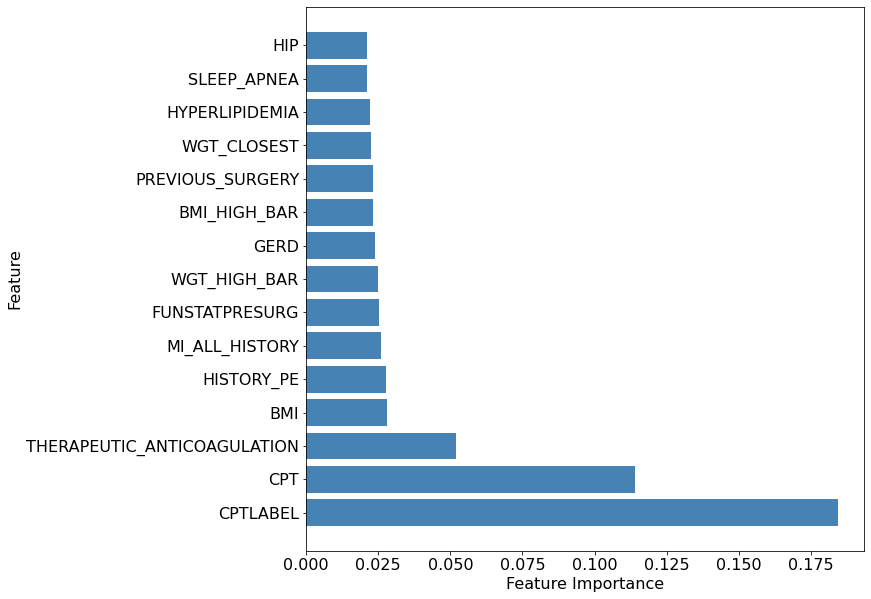

In [48]:
# %%
#plot the top 15 feature on a horizontal bar chart, with highest on the top
plt.figure(figsize=(10,10))
plt.barh(np.arange(15), fi[fi_sorted], color='steelblue')
plt.yticks(np.arange(15), X.columns[fi_sorted])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.savefig('xgb_fi_bleed_cptdc_nopost_noint_ab.png', bbox_inches='tight')

In [49]:
rf.fit(X, y)
fi = rf.feature_importances_
fi_sorted = np.argsort(fi)
fi_sorted = fi_sorted[::-1]
fi_sorted = fi_sorted[:15]

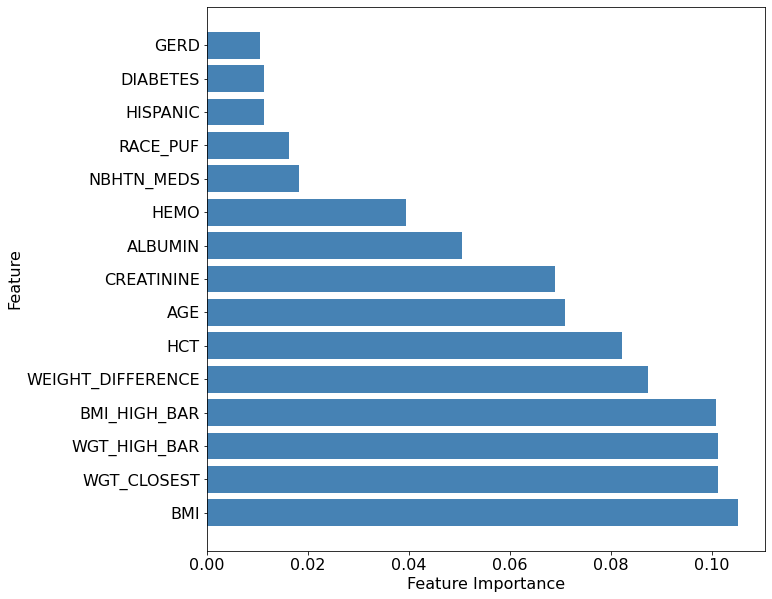

In [50]:
# %%
#plot the top 15 feature on a horizontal bar chart, with highest on the top
plt.figure(figsize=(10,10))
plt.barh(np.arange(15), fi[fi_sorted], color='steelblue')
plt.yticks(np.arange(15), X.columns[fi_sorted])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.savefig('rf_fi_bleed_cptdc_nopost_noint_ab.png', bbox_inches='tight')

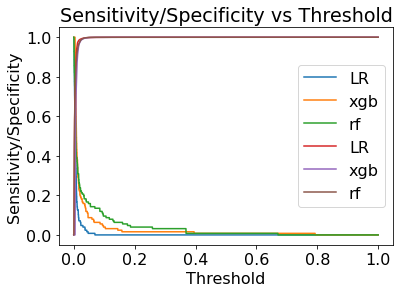

In [51]:
# %%
from sklearn.metrics import recall_score
from imblearn.metrics import specificity_score
import numpy as np
thresh = np.arange(0, 1, 0.00001)
#create a dataframe to store the sensitivity and specificity at each threshold for each model
lr_senspec = pd.DataFrame(columns=['thresh', 'sens','spec'])
xgb_senspec = pd.DataFrame(columns=['thresh', 'sens','spec'])
rf_senspec = pd.DataFrame(columns=['thresh', 'sens','spec'])
lr_sens = {}
lr_spec = {}
xgb_sens = {}
xgb_spec = {}
rf_sens = {}
rf_spec = {}
for t in thresh:
    lr_sens[t] = recall_score(y_test, lr_y_pred > t)
    lr_spec[t] = specificity_score(y_test, lr_y_pred > t)
    xgb_sens[t] = recall_score(y_test, xgb_y_pred > t)
    xgb_spec[t] = specificity_score(y_test, xgb_y_pred > t)
    rf_sens[t] = recall_score(y_test, rf_y_pred > t)
    rf_spec[t] = specificity_score(y_test, rf_y_pred > t)
#add each dictionary to the dataframe
lr_senspec['thresh'] = lr_sens.keys()
lr_senspec['sens'] = lr_sens.values()
lr_senspec['spec'] = lr_spec.values()
xgb_senspec['thresh'] = xgb_sens.keys()
xgb_senspec['sens'] = xgb_sens.values()
xgb_senspec['spec'] = xgb_spec.values()
rf_senspec['thresh'] = rf_sens.keys()
rf_senspec['sens'] = rf_sens.values()
rf_senspec['spec'] = rf_spec.values()
#plot the sensitivity and specificity
plt.plot(lr_senspec['thresh'], lr_senspec['sens'], label='LR')
plt.plot(xgb_senspec['thresh'], xgb_senspec['sens'], label='xgb')
plt.plot(rf_senspec['thresh'], rf_senspec['sens'], label='rf')
plt.plot(lr_senspec['thresh'], lr_senspec['spec'], label='LR')
plt.plot(xgb_senspec['thresh'], xgb_senspec['spec'], label='xgb')
plt.plot(rf_senspec['thresh'], rf_senspec['spec'], label='rf')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Sensitivity/Specificity')
plt.title('Sensitivity/Specificity vs Threshold')
plt.show()

In [52]:
# %%
xgb_senatspec = {}
rf_senatspec = {}
lr_senatspec = {}
#find the value for xgb sensitivity where specificity is close to 90%
xgb_senatspec[90] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],1) == 0.900]).split()[1])
rf_senatspec[90] = float(str(rf_senspec['sens'].loc[round(rf_senspec['spec'],1) == 0.900]).split()[1])
lr_senatspec[90] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],1) == 0.900]).split()[1])

xgb_senatspec[70] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],1) == 0.700]).split()[1])
rf_senatspec[70] = float(str(rf_senspec['sens'].loc[round(rf_senspec['spec'],1) == 0.700]).split()[1])
lr_senatspec[70] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],1) == 0.700]).split()[1])

xgb_senatspec[50] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],1) == 0.500]).split()[1])
rf_senatspec[50] = float(str(rf_senspec['sens'].loc[round(rf_senspec['spec'],1) == 0.500]).split()[1])
lr_senatspec[50] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],1) == 0.500]).split()[1])

xgb_senatspec[30] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],1) == 0.300]).split()[1])
rf_senatspec[30] = float(str(rf_senspec['sens'].loc[round(rf_senspec['spec'],1) == 0.300]).split()[1])
lr_senatspec[30] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],1) == 0.300]).split()[1])

In [53]:
# %%
xgb_senatspec[10] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],1) == 0.100]).split()[1])
rf_senatspec[10] = float(str(rf_senspec['sens'].loc[round(rf_senspec['spec'],1) == 0.100]).split()[1])
lr_senatspec[10] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],1) == 0.100]).split()[1])

<AxesSubplot:>

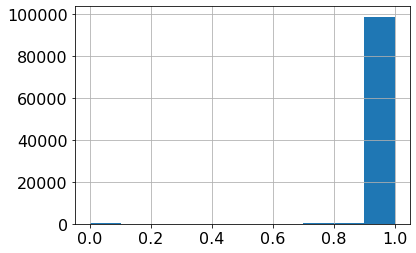

In [54]:
# %%
xgb_senspec['spec'].hist()

In [55]:
# %%
#write xgb_senatspec to a csv file
xgb_senatspec_df = pd.DataFrame.from_dict(xgb_senatspec, orient='index')
xgb_senatspec_df.columns = ['sensitivity']
#rename index to 'specificity'
xgb_senatspec_df.index.name = 'specificity'
xgb_senatspec_df.to_csv('xgb_senspec_bleed_cptdc_nopost_noint_ab.csv')

rf_senatspec_df = pd.DataFrame.from_dict(rf_senatspec, orient='index')
rf_senatspec_df.columns = ['sensitivity']
#rename index to 'specificity'
rf_senatspec_df.index.name = 'specificity'
rf_senatspec_df.to_csv('rf_senspec_bleed_cptdc_nopost_noint_ab.csv')

lr_senatspec_df = pd.DataFrame.from_dict(lr_senatspec, orient='index')
lr_senatspec_df.columns = ['sensitivity']
#rename index to 'specificity'
lr_senatspec_df.index.name = 'specificity'
lr_senatspec_df.to_csv('lr_senspec_bleed_cptdc_nopost_noint_ab.csv')